In [2]:
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("StressNotebook") \
    .getOrCreate()

df = spark.read.option("header", "true").option("inferSchema", "true") \
    .csv("hdfs://localhost:9000/user/vince/datasets/Student_Mental_Stress_and_Coping_Mechanisms.csv")

df.show(5)

+-----------+---+------+--------------------------+--------------------+----------------------------------+--------------------------------+----------------------------------+----------------+----------------+-------------+-------------------+-------------------+---------------------+------------+------------------------+---------------------+----------------------------+-----------------+-------------+
| Student ID|Age|Gender|Academic Performance (GPA)|Study Hours Per Week|Social Media Usage (Hours per day)|Sleep Duration (Hours per night)|Physical Exercise (Hours per week)|Family Support  |Financial Stress|Peer Pressure|Relationship Stress|Mental Stress Level|Counseling Attendance|Diet Quality|Stress Coping Mechanisms|Cognitive Distortions|Family Mental Health History|Medical Condition|Substance Use|
+-----------+---+------+--------------------------+--------------------+----------------------------------+--------------------------------+----------------------------------+-----------

In [7]:
from pyspark.sql.functions import avg, stddev, min, max

df = df.toDF(*[c.strip() for c in df.columns])

df.select(
    avg("Mental Stress Level").alias("Moyenne Stress"),
    stddev("Mental Stress Level").alias("Écart-type Stress"),
    min("Mental Stress Level").alias("Min Stress"),
    max("Mental Stress Level").alias("Max Stress"),
    avg("Sleep Duration (Hours per night)").alias("Moyenne Sommeil"),
    avg("Social Media Usage (Hours per day)").alias("Moyenne Réseaux"),
    avg("Academic Performance (GPA)").alias("Moyenne GPA")
).show()

df.groupBy("Gender").count().show()
print("Corrélation Stress ↔ Sommeil :", df.stat.corr("Mental Stress Level", "Sleep Duration (Hours per night)"))
print("Corrélation Stress ↔ Réseaux Sociaux :", df.stat.corr("Mental Stress Level", "Social Media Usage (Hours per day)"))
print("Corrélation GPA ↔ Sommeil :", df.stat.corr("Academic Performance (GPA)", "Sleep Duration (Hours per night)"))
df.groupBy("Gender").agg(avg("Mental Stress Level").alias("Stress moyen")).show()

+-----------------+-----------------+----------+----------+-----------------+-----------------+------------------+
|   Moyenne Stress|Écart-type Stress|Min Stress|Max Stress|  Moyenne Sommeil|  Moyenne Réseaux|       Moyenne GPA|
+-----------------+-----------------+----------+----------+-----------------+-----------------+------------------+
|5.363157894736842|2.902855897173186|         1|        10|8.093421052631578|4.234210526315789|1.9960526315789473|
+-----------------+-----------------+----------+----------+-----------------+-----------------+------------------+

+-----------+-----+
|     Gender|count|
+-----------+-----+
|Genderqueer|    7|
|    Agender|   14|
|     Female|  336|
| Polygender|   12|
|   Bigender|   16|
| Non-binary|   10|
|       Male|  353|
|Genderfluid|   12|
+-----------+-----+

Corrélation Stress ↔ Sommeil : 0.06802653795478464
Corrélation Stress ↔ Réseaux Sociaux : 0.011564155386168392
Corrélation GPA ↔ Sommeil : -0.01744982013336548
+-----------+----------

In [8]:
print("Dimensions du dataset")
nb_lignes = df.count()
nb_colonnes = len(df.columns)
print(f"- Nombre de lignes : {nb_lignes}")
print(f"- Nombre de colonnes : {nb_colonnes}")

print("\nListe des colonnes")
print(df.columns)

Dimensions du dataset
- Nombre de lignes : 760
- Nombre de colonnes : 20

Liste des colonnes
['Student ID', 'Age', 'Gender', 'Academic Performance (GPA)', 'Study Hours Per Week', 'Social Media Usage (Hours per day)', 'Sleep Duration (Hours per night)', 'Physical Exercise (Hours per week)', 'Family Support', 'Financial Stress', 'Peer Pressure', 'Relationship Stress', 'Mental Stress Level', 'Counseling Attendance', 'Diet Quality', 'Stress Coping Mechanisms', 'Cognitive Distortions', 'Family Mental Health History', 'Medical Condition', 'Substance Use']


In [27]:
pdf = df.toPandas()

types_et_nulls = pd.DataFrame({
    "Type": pdf.dtypes,
    "Non nuls": pdf.notnull().sum(),
    "Nuls": pdf.isnull().sum()
})
print(types_et_nulls)

                                      Type  Non nuls  Nuls
Student ID                          object       760     0
Age                                  int32       760     0
Gender                              object       760     0
Academic Performance (GPA)           int32       760     0
Study Hours Per Week                 int32       760     0
Social Media Usage (Hours per day)   int32       760     0
Sleep Duration (Hours per night)     int32       760     0
Physical Exercise (Hours per week)   int32       760     0
Family Support                       int32       760     0
Financial Stress                     int32       760     0
Peer Pressure                        int32       760     0
Relationship Stress                  int32       760     0
Mental Stress Level                  int32       760     0
Counseling Attendance               object       760     0
Diet Quality                         int32       760     0
Stress Coping Mechanisms            object       760    

In [11]:
print("Statistiques descriptives des variables numériques")
print(pdf.describe())

Statistiques descriptives des variables numériques
              Age  Academic Performance (GPA)  Study Hours Per Week  \
count  760.000000                  760.000000            760.000000   
mean    23.919737                    1.996053             29.130263   
std      3.819392                    1.416535             18.104662   
min     18.000000                    0.000000              0.000000   
25%     21.000000                    1.000000             13.000000   
50%     24.000000                    2.000000             29.000000   
75%     27.000000                    3.000000             45.000000   
max     30.000000                    4.000000             60.000000   

       Social Media Usage (Hours per day)  Sleep Duration (Hours per night)  \
count                          760.000000                        760.000000   
mean                             4.234211                          8.093421   
std                              2.565174                          2.596

In [12]:
print("Valeurs uniques par colonne catégorielle")
cat_cols = pdf.select_dtypes(include="object").columns

for col in cat_cols:
    print(f"- {col} ({pdf[col].nunique()} valeurs uniques) : {pdf[col].unique()[:5]}")

Valeurs uniques par colonne catégorielle
- Student ID (760 valeurs uniques) : ['802-17-3671' '871-12-8572' '495-13-2672' '365-77-2496' '664-76-5622']
- Gender (8 valeurs uniques) : ['Female' 'Male' 'Agender' 'Bigender' 'Genderfluid']
- Counseling Attendance (2 valeurs uniques) : ['No' 'Yes']
- Stress Coping Mechanisms (10 valeurs uniques) : ['Walking or Nature Walks' 'Meditation' 'Reading'
 'Social Media Engagement' 'Exercise']
- Family Mental Health History (2 valeurs uniques) : ['No' 'Yes']
- Medical Condition (2 valeurs uniques) : ['Yes' 'No']


In [13]:
print("Distribution de 'Mental Stress Level'")
print(pdf["Mental Stress Level"].value_counts().sort_index())

Distribution de 'Mental Stress Level'
Mental Stress Level
1     81
2     89
3     74
4     76
5     80
6     70
7     70
8     74
9     71
10    75
Name: count, dtype: int64


/var/folders/gx/l03ggcg526j_gh4jnx47st700000gn/T/ipykernel_71489/3345161867.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=pdf, x="Mental Stress Level", palette="coolwarm")


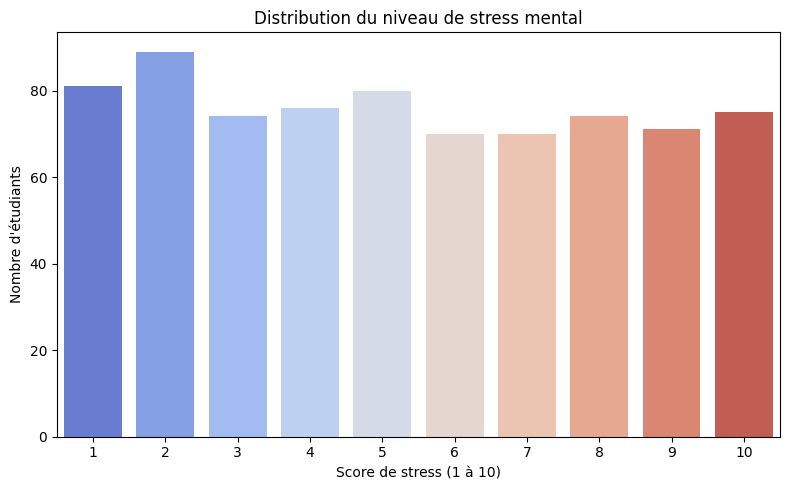

In [14]:
plt.figure(figsize=(8, 5))
sns.countplot(data=pdf, x="Mental Stress Level", palette="coolwarm")
plt.title("Distribution du niveau de stress mental")
plt.xlabel("Score de stress (1 à 10)")
plt.ylabel("Nombre d'étudiants")
plt.tight_layout()
plt.show()

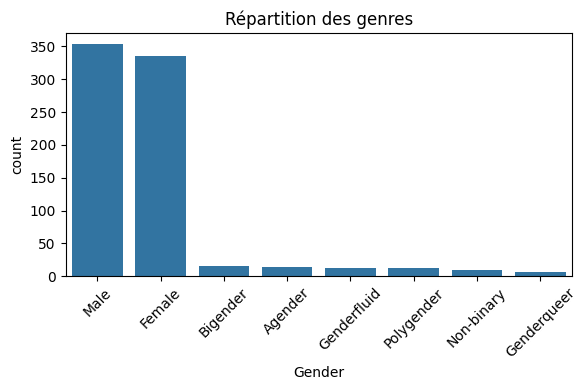

In [15]:
plt.figure(figsize=(6, 4))
sns.countplot(data=pdf, x="Gender", order=pdf["Gender"].value_counts().index)
plt.title("Répartition des genres")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

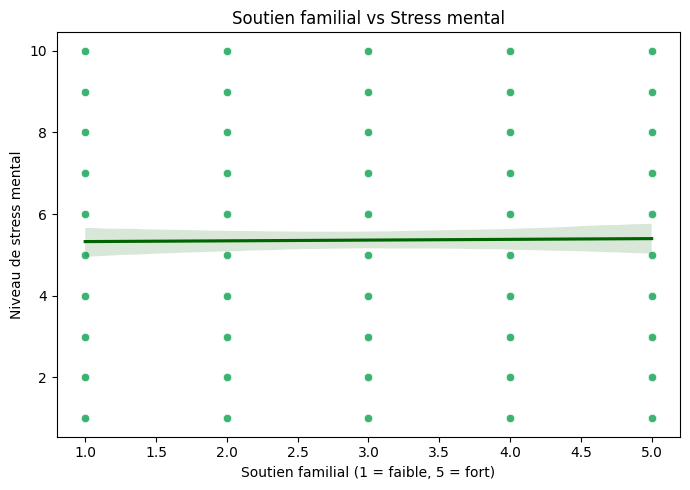

Corrélation entre le soutien familial et le stress : 0.01


In [16]:
plt.figure(figsize=(7, 5))
sns.scatterplot(data=pdf, x="Family Support", y="Mental Stress Level", color="mediumseagreen")
sns.regplot(data=pdf, x="Family Support", y="Mental Stress Level", scatter=False, color="darkgreen")
plt.title("Soutien familial vs Stress mental")
plt.xlabel("Soutien familial (1 = faible, 5 = fort)")
plt.ylabel("Niveau de stress mental")
plt.tight_layout()
plt.show()

correlation = pdf["Family Support"].corr(pdf["Mental Stress Level"])
print(f"Corrélation entre le soutien familial et le stress : {correlation:.2f}")

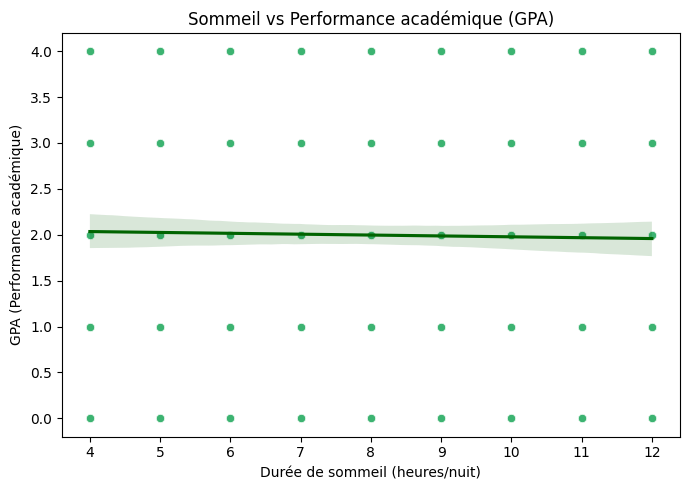

Corrélation Sommeil ↔ GPA : -0.02


In [17]:
plt.figure(figsize=(7, 5))
sns.scatterplot(
    data=pdf,
    x="Sleep Duration (Hours per night)",
    y="Academic Performance (GPA)",
    color="mediumseagreen"
)
sns.regplot(
    data=pdf,
    x="Sleep Duration (Hours per night)",
    y="Academic Performance (GPA)",
    scatter=False,
    color="darkgreen"
)
plt.title("Sommeil vs Performance académique (GPA)")
plt.xlabel("Durée de sommeil (heures/nuit)")
plt.ylabel("GPA (Performance académique)")
plt.tight_layout()
plt.show()

correlation = pdf["Sleep Duration (Hours per night)"].corr(pdf["Academic Performance (GPA)"])
print(f"Corrélation Sommeil ↔ GPA : {correlation:.2f}")

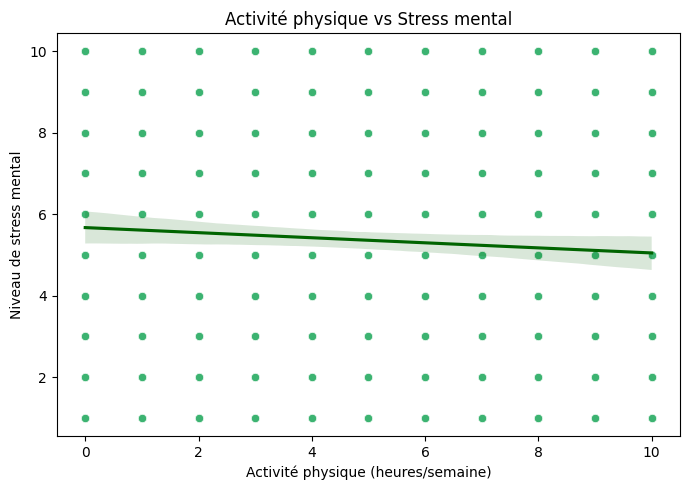

Corrélation Activité physique ↔ Stress mental : -0.07


In [18]:
plt.figure(figsize=(7, 5))
sns.scatterplot(
    data=pdf,
    x="Physical Exercise (Hours per week)",
    y="Mental Stress Level",
    color="mediumseagreen"
)
sns.regplot(
    data=pdf,
    x="Physical Exercise (Hours per week)",
    y="Mental Stress Level",
    scatter=False,
    color="darkgreen"
)
plt.title("Activité physique vs Stress mental")
plt.xlabel("Activité physique (heures/semaine)")
plt.ylabel("Niveau de stress mental")
plt.tight_layout()
plt.show()

correlation = pdf["Physical Exercise (Hours per week)"].corr(pdf["Mental Stress Level"])
print(f"Corrélation Activité physique ↔ Stress mental : {correlation:.2f}")


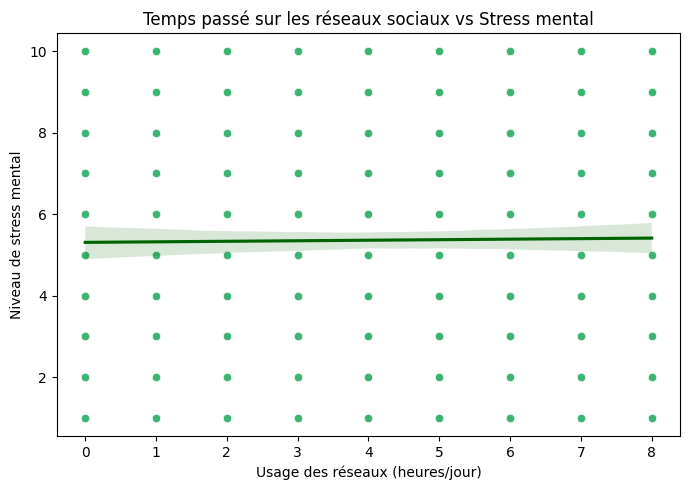

Corrélation Réseaux Sociaux ↔ Stress mental : 0.01


In [19]:
plt.figure(figsize=(7, 5))
sns.scatterplot(
    data=pdf,
    x="Social Media Usage (Hours per day)",
    y="Mental Stress Level",
    color="mediumseagreen"
)
sns.regplot(
    data=pdf,
    x="Social Media Usage (Hours per day)",
    y="Mental Stress Level",
    scatter=False,
    color="darkgreen"
)
plt.title("Temps passé sur les réseaux sociaux vs Stress mental")
plt.xlabel("Usage des réseaux (heures/jour)")
plt.ylabel("Niveau de stress mental")
plt.tight_layout()
plt.show()

correlation = pdf["Social Media Usage (Hours per day)"].corr(pdf["Mental Stress Level"])
print(f"Corrélation Réseaux Sociaux ↔ Stress mental : {correlation:.2f}")

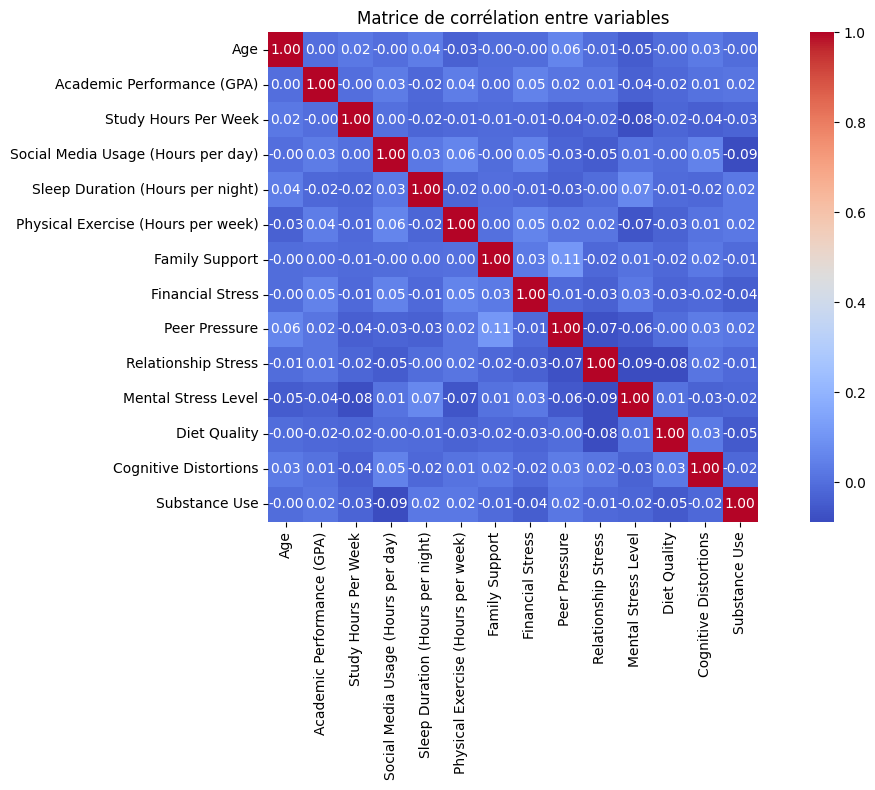

In [20]:
correlation_matrix = pdf.corr(numeric_only=True)

plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title("Matrice de corrélation entre variables")
plt.tight_layout()
plt.show()

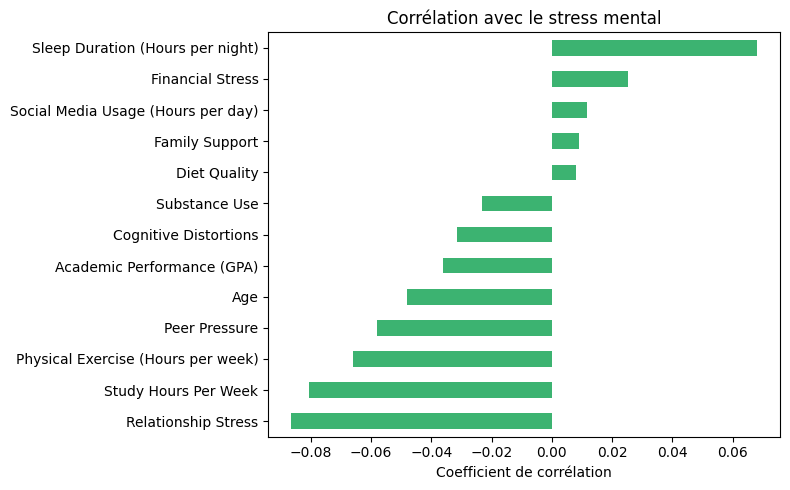

In [21]:
cor_stress = correlation_matrix["Mental Stress Level"].drop("Mental Stress Level")

plt.figure(figsize=(8, 5))
cor_stress.sort_values().plot(kind='barh', color='mediumseagreen')
plt.title("Corrélation avec le stress mental")
plt.xlabel("Coefficient de corrélation")
plt.tight_layout()
plt.show()

Gender                    Agender  Bigender  Female  Genderfluid  Genderqueer  \
Stress Coping Mechanisms                                                        
Exercise                        3         2      26            2            0   
Meditation                      1         2      32            1            0   
Reading                         0         1      34            1            1   
Social Media Engagement         1         1      38            1            2   
Spending Time Alone             2         2      35            0            1   
Talking to Friends              1         1      29            0            1   
Travelling                      1         2      43            2            0   
Walking or Nature Walks         0         1      37            1            0   
Watching Sports                 2         2      29            3            2   
Yoga                            3         2      33            1            0   

Gender                    M

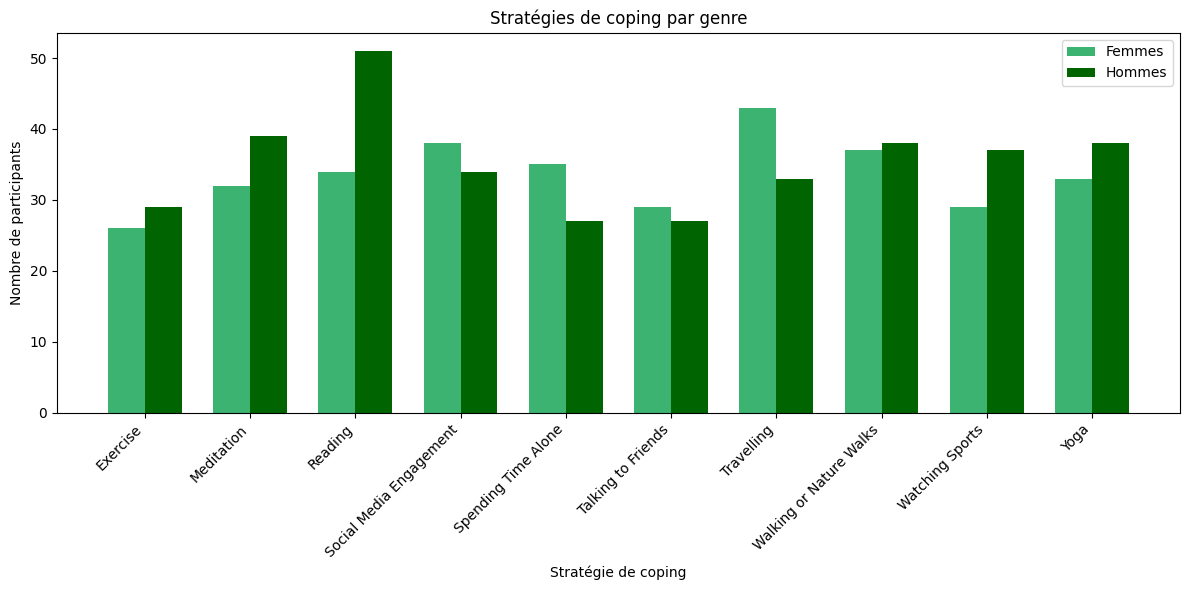

In [25]:
coping_table = pd.crosstab(pdf["Stress Coping Mechanisms"], pdf["Gender"])
print(coping_table)

strategies = coping_table.index.tolist()
x = np.arange(len(strategies))
width = 0.35

plt.figure(figsize=(12, 6))
plt.bar(x - width/2, coping_table["Female"], width, label='Femmes', color='mediumseagreen')
plt.bar(x + width/2, coping_table["Male"], width, label='Hommes', color='darkgreen')

plt.xticks(x, strategies, rotation=45, ha='right')
plt.title("Stratégies de coping par genre")
plt.xlabel("Stratégie de coping")
plt.ylabel("Nombre de participants")
plt.legend()
plt.tight_layout()
plt.show()

Corrélation Sommeil ↔ GPA : -0.02


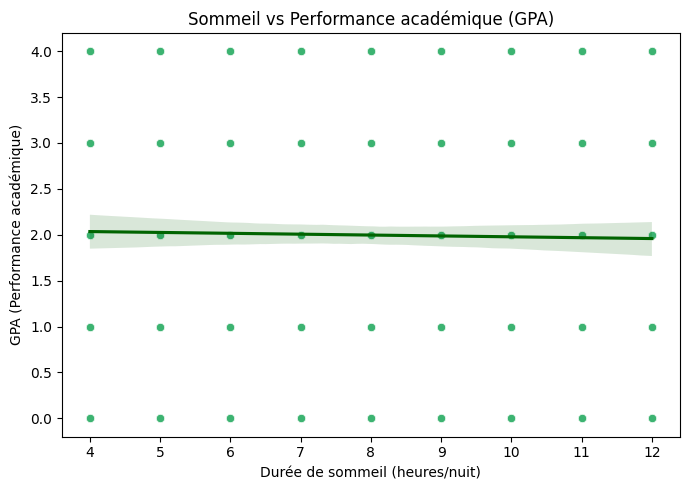

In [26]:
correlation = pdf["Sleep Duration (Hours per night)"].corr(pdf["Academic Performance (GPA)"])
print(f"Corrélation Sommeil ↔ GPA : {correlation:.2f}")

plt.figure(figsize=(7, 5))
sns.scatterplot(
    data=pdf,
    x="Sleep Duration (Hours per night)",
    y="Academic Performance (GPA)",
    color="mediumseagreen"
)
sns.regplot(
    data=pdf,
    x="Sleep Duration (Hours per night)",
    y="Academic Performance (GPA)",
    scatter=False,
    color="darkgreen"
)
plt.title("Sommeil vs Performance académique (GPA)")
plt.xlabel("Durée de sommeil (heures/nuit)")
plt.ylabel("GPA (Performance académique)")
plt.tight_layout()
plt.show()